# Xenium mouse brain

In this notebook, we will use ovrlpy to investigate the [Xenium's mouse brain dataset](https://www.10xgenomics.com/products/xenium-in-situ/mouse-brain-dataset-explorer).

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.

## Settings and Imports

First we import relevant analysis packages and set the paths to the data files.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import ovrlpy

The data file can be downloaded from the link above, and the signatures are available from the GitHub repository (see [here](https://github.com/HiDiHlabs/ovrl.py/tree/main/docs/source/tutorials/xenium_mouse_brain_data)).

In [2]:
# TODO: adjust paths
data_path = Path("path/to/downloaded_data/replicate1")

signature_matrix_file = Path(
    "./xenium_mouse_brain_data/celltype_signatures_brain.csv.gz"
)

## Loading the data

Now, we want to load the data and prepare it for analysis.

In [3]:
coordinate_df = ovrlpy.io.read_Xenium(data_path / "transcripts.parquet")

coordinate_df.head()

gene,x,y,z
cat,f32,f32,f32
"""Bhlhe40""",4843.045898,6427.72998,19.068869
"""Parm1""",4844.632812,6223.182617,18.520161
"""Bhlhe40""",4842.943359,6478.310547,18.500109
"""Lyz2""",4843.941406,6344.550293,15.016154
"""Dkk3""",4843.162598,6632.111816,15.39468


Let's get a quick overview of the tissue

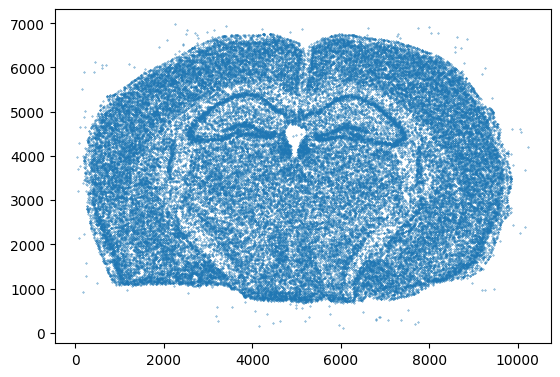

In [4]:
# only show every 1,000th transcript
n = 1_000

fig, ax = plt.subplots()
ax.scatter(coordinate_df[::n, "x"], coordinate_df[::n, "y"], s=0.1)
_ = ax.set(aspect="equal")

## Running the ovrlpy pipeline

ovrlpy provides a convenience function `run` to run the entire pipeline. 
The function creates a signal integrity map, a signal strength map and a Visualizer obejcet to visualize the results.

In [5]:
# ensure reproducibility by setting random_state
brain = ovrlpy.Ovrlp(coordinate_df, n_workers=8, random_state=42)
brain.analyse()

Running vertical adjustment
Creating gene expression embeddings for visualization
determining pseudocells
found 59237 pseudocells
sampling expression:


100%|██████████| 54/54 [01:15<00:00,  1.40s/it]


Modeling 30 pseudo-celltype clusters;
Creating signal integrity map


100%|██████████| 315/315 [07:51<00:00,  1.50s/it]


## Visualizing results

The visualizer object has a plotting method to show the embeddings of the sampled gene expression signal.

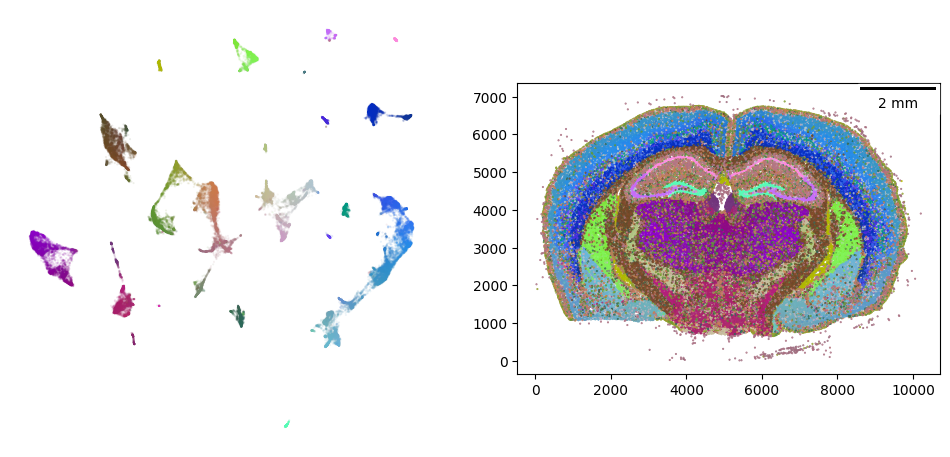

In [6]:
_ = ovrlpy.plot_pseudocells(brain)

We can annotate the UMAP using external, single-cell derived cell type signatures to help interpret the cell type clusters in the gene-expression embedding. Cell type signatures can be created by using the mean gene expression per cell type (or annotation of interest) of a reference dataset.

In [7]:
signatures = pd.read_csv(signature_matrix_file, index_col="gene").T
signatures = signatures.loc[:, signatures.columns.isin(brain.genes)]
signatures.index.name = "celltype"

signatures.iloc[:5, :5]

gene,2010300C02Rik,Acsbg1,Acta2,Acvrl1,Adamts2
celltype,,,,,
Astro,0.000,3.593,0.0,0.0,0.00000
CA1,7.464,0.000,0.0,0.0,0.69060
CA2,9.587,0.000,0.0,0.0,0.00000
CA3,6.306,0.000,0.0,0.0,0.09887
CR,0.000,0.000,0.0,0.0,0.00000


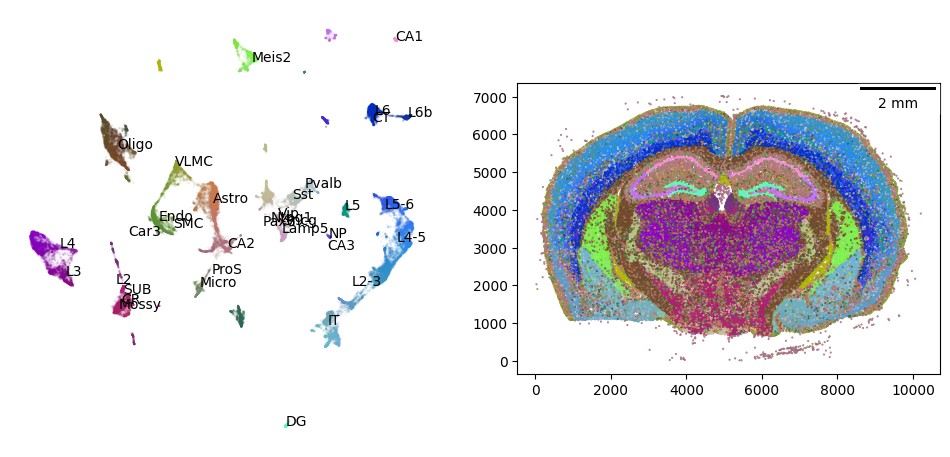

In [8]:
brain.fit_signatures(signatures)
_ = ovrlpy.plot_pseudocells(brain)

In the same way, the signal integrity map can be visualized, where visualization is cut off at regions below a certain signal strength threshold:

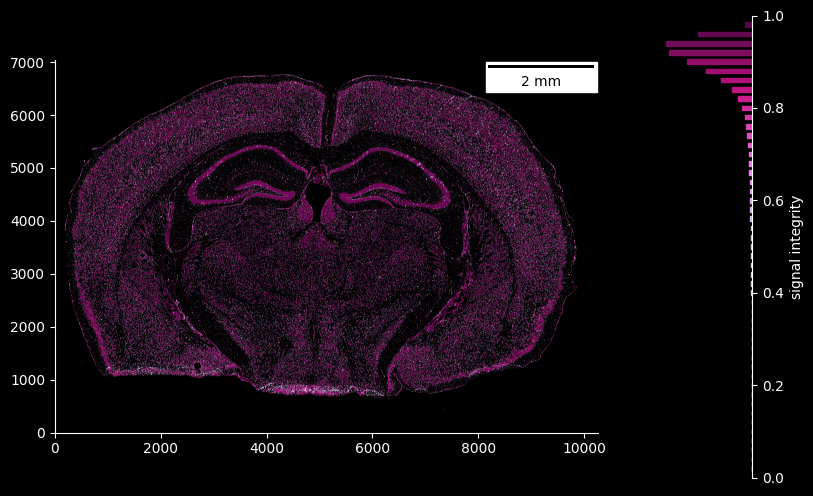

In [9]:
fig = ovrlpy.plot_signal_integrity(brain, signal_threshold=3)

## Detecting doublets 

We can detect individual doublet events with ovrlpy, again setting a signal strength threshold to filter out low-transcript regions:

In [10]:
doublets = brain.detect_doublets(min_signal=3, integrity_sigma=2)

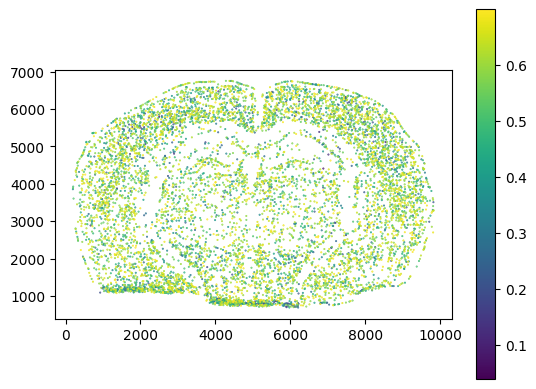

In [11]:
fig, ax = plt.subplots()
_scatter = ax.scatter(
    doublets["x"], doublets["y"], c=doublets["integrity"], s=0.2, cmap="viridis"
)
_ = ax.set_aspect("equal")
_ = fig.colorbar(_scatter, ax=ax)

Having sampled regions of potential doublets, we can visualize them as close-up transcriptome molecule clouds through the Visualizer's learned color embeddings - by providing their (x, y) locations to `ovrlpy.plot_region_of_interest`

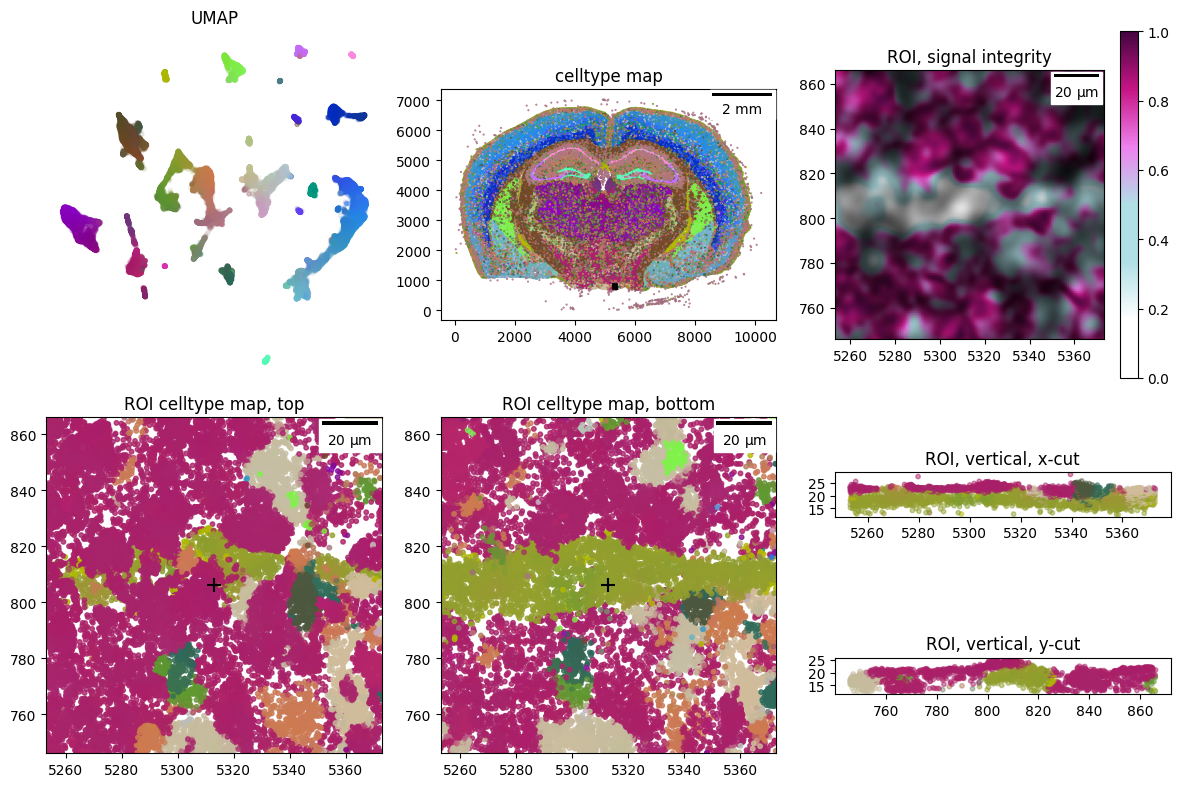

In [12]:
doublet_case = 0

x, y = doublets["x", "y"].row(doublet_case)

_ = ovrlpy.plot_region_of_interest(brain, x, y, window_size=60)

## Other functionality

Furthermore, we can save the visualizer object to file for later use leveraging the `pickle` module

In [13]:
import pickle

with open("my_analysis.pickle", "wb") as file:
    pickle.dump(brain, file)

... and easily reload it if needed.

In [14]:
with open("my_analysis.pickle", "rb") as file:
    brain = pickle.load(file)

Additionally, the analysis has produced a global z-level adjustment of the transcriptome coordinates, which can be used to create a z-stack of adjacent, aligned sections in silico:

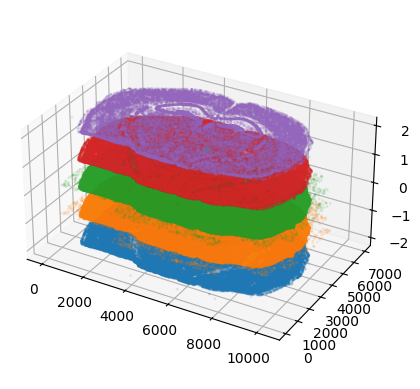

In [15]:
import polars as pl

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

for i in range(-2, 3):
    subset = brain.transcripts.filter(
        (pl.col("z") - pl.col("z_center")).is_between(i, i + 1)
    )
    # downsample the number of transcripts
    subset = subset[::100]

    ax.scatter(subset["x"], subset["y"], i, s=1, alpha=0.1)

ratio = brain.transcripts["x"].max() / brain.transcripts["y"].max()
ax.set_box_aspect([ratio, 1, 0.75])